In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm

### Load up Gaia results
#### (see adql_query.txt for query)

In [2]:
gaia = np.genfromtxt('../hjhosts-result.csv', delimiter=',', unpack=True, names=True, dtype=None, encoding=None)

In [3]:
table = pd.DataFrame.from_records(gaia)

In [4]:
table = table.rename(columns={'col1':'kep_ra', 'col2':'kep_dec', 'col3':'kepmag', 'col4':'kepid'})

#### Calculate better angular separations that take propagated proper motion into account:

In [5]:
refCoord = coord.SkyCoord(ra=table['kep_ra'].values * u.degree, 
                          dec=table['kep_dec'].values * u.degree)        

In [6]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time(table['ref_epoch'], format='jyear')
gaiaCoord = coord.SkyCoord(ra=table['ra'].values * u.degree, 
                           dec=table['dec'].values * u.degree, 
                           distance=(table['parallax'].values * u.milliarcsecond).to(u.pc, u.parallax()),
                           radial_velocity=table['radial_velocity'].values * u.km / u.s,
                           pm_ra_cosdec=table['pmra'].values * u.milliarcsecond / u.year, 
                           pm_dec=table['pmdec'].values * u.milliarcsecond / u.year, 
                           obstime=gaia_time
                            )
sep = refCoord.separation(gaiaCoord)
ind = np.where(sep > 10. * u.deg)[0]
for i in ind:
        sep[i] = 180.*u.deg - sep[i] # HACK

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site

In [7]:
table['ang_dist_w_pm'] = sep.arcsec

Check on the best matches:

In [8]:
matches = table.sort_values(['kepid', 'ang_dist_w_pm'], inplace=False)
matches.drop_duplicates('kepid', inplace=True)

(array([254.,   2.,   1.,   3.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([7.20163253e-03, 1.77337315e+00, 3.53954467e+00, 5.30571618e+00,
        7.07188770e+00, 8.83805922e+00, 1.06042307e+01, 1.23704022e+01,
        1.41365738e+01, 1.59027453e+01, 1.76689168e+01]),
 <a list of 10 Patch objects>)

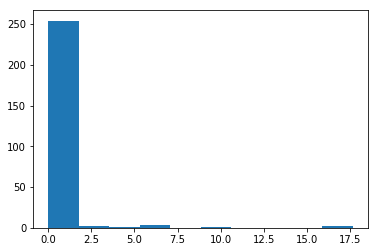

In [9]:
plt.hist(matches['ang_dist_w_pm'])

In [10]:
matches[matches['ang_dist_w_pm'] > 5.]

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,lum_percentile_upper,datalink_url,epoch_photometry_url,hjhosts_oid,kep_ra,kep_dec,kepmag,kepid,ang_dist,ang_dist_w_pm
23910,1635721458409799680,Gaia DR2 2101508501301082368,2101508501301082368,1004772443,2015.5,291.283725,0.027139,40.727728,0.037741,0.382788,...,3.000779,http://geadata.esac.esa.int/data-server/datali...,,115,291.28500,40.730049,15.855,5531953,0.002514,9.051935
43979,1635721458409799680,Gaia DR2 2076660672388510464,2076660672388510464,1039014877,2015.5,294.960202,0.072132,40.985350,0.098499,0.100101,...,NaN,http://geadata.esac.esa.int/data-server/datali...,,208,294.96027,40.986980,15.423,5716244,0.001631,5.871694
48799,1635721458409799680,Gaia DR2 2080091492257542144,2080091492257542144,325514623,2015.5,294.993792,0.206241,46.223899,0.212958,0.269455,...,NaN,http://geadata.esac.esa.int/data-server/datali...,,234,294.99121,46.223572,14.538,9596187,0.001816,6.537878
18147,1635721458409799680,Gaia DR2 2086324275778825600,2086324275778825600,184412114,2015.5,297.652861,0.211104,47.167175,0.206432,0.154450,...,NaN,http://geadata.esac.esa.int/data-server/datali...,,90,297.64606,47.167488,13.592,10158418,0.004634,16.683767
21791,1635721458409799680,Gaia DR2 2130856356427181568,2130856356427181568,349879453,2015.5,287.706976,0.324227,47.333921,0.559335,0.027589,...,NaN,http://geadata.esac.esa.int/data-server/datali...,,104,287.70883,47.333050,12.128,10264660,0.001529,5.503737
39409,1635721458409799680,Gaia DR2 2119616182197267200,2119616182197267200,981221805,2015.5,281.772358,0.145839,47.597664,0.166030,0.227139,...,NaN,http://geadata.esac.esa.int/data-server/datali...,,191,281.77554,47.593250,14.371,10384962,0.004908,17.668917


In [11]:
from utils import *

In [12]:
kepids = np.unique(table['kepid'].values)

In [43]:
columns = ['kic_primary','gaia_id_primary', 'gaia_id_match', 'ra_match', 'dec_match', 'chisq']
matches_table = pd.DataFrame(columns=columns)

In [44]:
def add_to_matches_table(match, primary, chisq, matches_table):
    matches_table = matches_table.append({'kic_primary': primary['kepid'], 
                          'gaia_id_primary': primary['source_id'], 
                          'gaia_id_match': match['source_id'], 
                          'ra_match': match['ra'], 
                          'dec_match': match['dec'], 
                          'chisq': chisq}, ignore_index=True)
    return matches_table

In [45]:
for k in tqdm(kepids):
    temp = table[table['kepid'] == k]
    best_match = temp.loc[temp['ang_dist_w_pm'].idxmin()]
    other_matches = temp.drop(temp['ang_dist_w_pm'].idxmin())
    chisqs = other_matches.apply(calc_chisq_for_pair, axis=1, args=(best_match,))
    for o,c in zip(other_matches.iterrows(), chisqs):
        if c > 0.:
            matches_table = add_to_matches_table(o[1], best_match, c, matches_table)

100%|██████████| 263/263 [03:23<00:00,  1.29it/s]


In [47]:
matches_table.to_csv('matches.csv')